# Importando as bibliotecas que serão necessárias para essa redução:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import astropy.units as u
from astropy.utils.data import download_file
from astropy.io import fits

from astropy.utils import data
data.conf.remote_timeout = 60

from spectral_cube import SpectralCube
from astropy import stats

from astroquery.esasky import ESASky
from astroquery.utils import TableList
from astropy.wcs import WCS
from reproject import reproject_interp

import radio_beam
from astropy.convolution import Gaussian1DKernel
from astropy.convolution import Gaussian2DKernel

ModuleNotFoundError: No module named 'astroquery'

# Abrindo o Cubo:

In [72]:
hi_data = fits.open("ngc4698.cube.fits")
cube = SpectralCube.read(hi_data)
hi_data.close()

$$\textrm{Verificando as informações contidas em cada eixo do cubo:}$$

In [73]:
print(cube)

SpectralCube with shape=(63, 512, 512) and unit=Jy / beam:
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   191.736000 deg:  192.454261 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:     8.131500 deg:    8.841228 deg
 n_s:     63  type_s: FREQ      unit_s: Hz     range: 1414162179.795 Hz:1417189523.545 Hz


$$\textrm{Fazendo o plot de um pequeno espectro:}$$

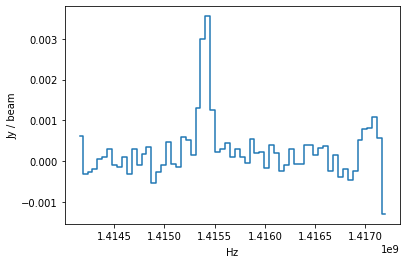

In [74]:
cube[:, 251, 237].quicklook()

In [75]:
# _, b, _ = cube.world[0, :, 0]  #extract latitude world coordinates from cube
# _, _, l = cube.world[0, 0, :]  #extract longitude world coordinates from cube

In [76]:
# # Define desired latitude and longitude range
# lat_range = [8.131500,8.211228] * u.deg 
# lon_range = [191.736000,191.815961] * u.deg

# # Create a sub_cube cut to these coordinates
# sub_cube = cube.subcube(xlo=lon_range[0], xhi=lon_range[1], ylo=lat_range[0], yhi=lat_range[1])

# print(sub_cube)

$$\textrm{Gerando os primeiros mapas de momento.}$$

$$\textrm{Momento 0 diz respeito ao mapa de Fluxo;}$$
$$\textrm{Momento 1 diz respeito ao mapa de velocidades.}$$

Para o momento 0, precisamos passar nosso eixo espectral para a unidade conveniente. Nesse caso, os cubos de VIVA têm momento 0 na unidade de $\frac{km\,Jy}{s\,beam}$, logo será essa a unidade que usaremos aqui.

In [77]:
moment_0 = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio').moment(order=0)

In [78]:
moment_1 = cube.with_spectral_unit(u.Hz).moment(order=1)

$$\textrm{Verificando as unidades de cada momento:}$$

In [79]:
print('Moment_0 tem a seguinte unidade: ', moment_0.unit)
print('Moment_1 tem a seguinte unidade: ', moment_1.unit)

Moment_0 tem a seguinte unidade:  Jy km / (beam s)
Moment_1 tem a seguinte unidade:  Hz


Corte ao longo do eixo espectral

In [80]:
slab = cube.spectral_slab(1414162179.795 * u.Hz, 1417189523.545 * u.Hz)
masked_slab = cube.with_mask(cube > -1.5332716e-07 * cube.unit)

In [81]:
# cube.std(axis=None, how='cube')

# Plotando os mapas de momento e salvando em arquivos .fits:

$$\textrm{Plotando o mapa de fluxo:}$$

<Figure size 432x288 with 0 Axes>

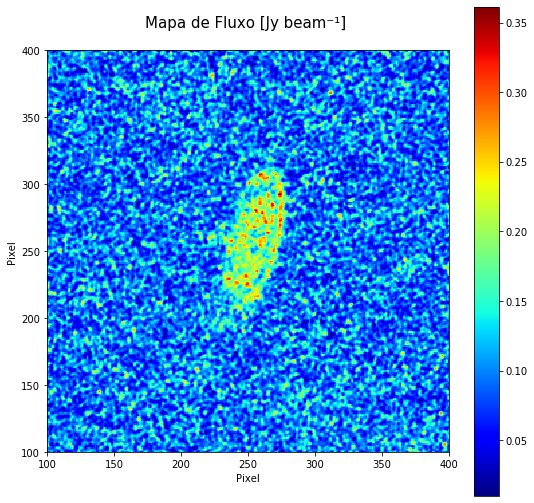

In [82]:
fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')
plt.figure(figsize=(9,9))
plt.imshow(masked_slab.with_spectral_unit(u.km/u.s, velocity_convention='radio').moment(order=0).hdu.data,
           cmap= 'jet')
plt.title("Mapa de Fluxo [Jy beam⁻¹] \n", fontsize=15)
plt.xlabel('Pixel')
plt.ylabel('Pixel')
plt.colorbar()
plt.xlim(100,400)
plt.ylim(100,400)
fig = plt.gcf()
plt.show()

# Obs.: Para salvar esse gráfico, descomente o seguinte comando:
# fig.savefig('NGC 4698 mapa de fluxo.png', format='png')

$$\textrm{Plotando o mapa de velocidades:}$$

<Figure size 432x288 with 0 Axes>

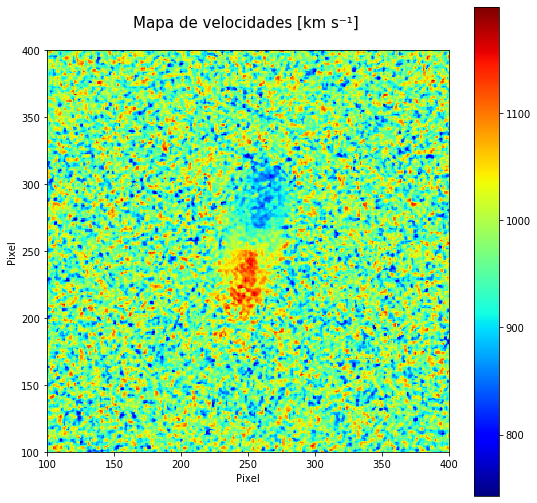

In [93]:
fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')
plt.figure(figsize=(9,9))
plt.imshow(masked_slab.with_spectral_unit(u.km/u.s, velocity_convention='radio').moment(order=1).hdu.data,
           cmap= 'jet')
plt.title("Mapa de velocidades [km s⁻¹] \n", fontsize=15)
plt.xlabel('Pixel')
plt.ylabel('Pixel')
plt.colorbar()
plt.xlim(100,400)
plt.ylim(100,400)
fig = plt.gcf()
plt.show()

# Obs.: Para salvar esse gráfico, descomente o seguinte comando:
# fig.savefig('NGC 4698 mapa de velocidades.png', format='png')

$$\textrm{Finalmente, salvando esses dados em um arquivo .fits pronto para fazer ciência:}$$

In [84]:
mom0 = masked_slab.with_spectral_unit(u.km/u.s, velocity_convention='radio').moment(order=0)

# mom0.write('HI_Moment_0.fits')

In [85]:
mom1 = masked_slab.with_spectral_unit(u.km/u.s, velocity_convention='radio').moment(order=1)

# mom1.write('HI_Moment_1.fits')

__________________________________________________________________________________________________________________

In [86]:
kernel = Gaussian2DKernel(x_stddev=2.5)
new_cube = cube.spatial_smooth(kernel)

kernel = Gaussian1DKernel(2.5)
new_cube = new_cube.spectral_smooth(kernel)

# moment_teste = new_cube.with_spectral_unit(u.km/u.s, velocity_convention='radio').moment(order=1)

In [87]:
new_slab = new_cube.spectral_slab(1414162179.795 * u.Hz, 1417189523.545 * u.Hz)
new_masked_slab = new_cube.with_mask(new_cube > -1.5332716e-07 * new_cube.unit)

# new_cube.write('some_other_file.fits')

/home/oliviernatanael/anaconda/lib/python3.7/site-packages/spectral_cube/_moments.py:169: RuntimeWarning: invalid value encountered in true_divide
  np.nansum(data, axis=axis))


<Figure size 432x288 with 0 Axes>

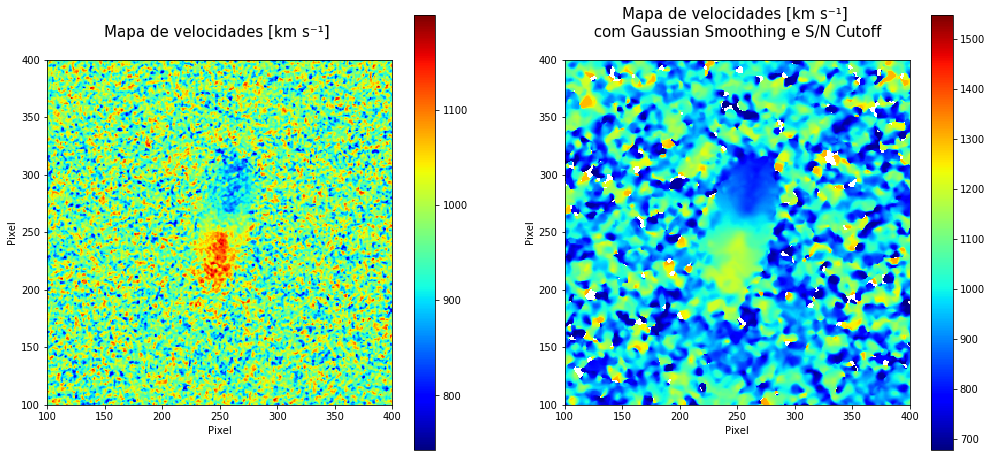

In [88]:
fig = plt.figure()
plt.figure(figsize=(17,8))

plt.subplot(1, 2, 1)
fig.patch.set_facecolor('xkcd:white')
# plt.figure(figsize=(9,9))
plt.imshow(masked_slab.with_spectral_unit(u.km/u.s, velocity_convention='radio').moment(order=1).hdu.data,
           cmap= 'jet')
plt.title("Mapa de velocidades [km s⁻¹] \n", fontsize=15)
plt.xlabel('Pixel')
plt.ylabel('Pixel')
plt.colorbar()
plt.xlim(100,400)
plt.ylim(100,400)
fig = plt.gcf()


plt.subplot(1, 2, 2)
fig.patch.set_facecolor('xkcd:white')
# plt.figure(figsize=(9,9))
plt.imshow(new_masked_slab.with_spectral_unit(u.km/u.s, velocity_convention='radio').moment(order=1).hdu.data,
           cmap= 'jet')
plt.title("Mapa de velocidades [km s⁻¹] \n com Gaussian Smoothing e S/N Cutoff \n", fontsize=15)
plt.xlabel('Pixel')
plt.ylabel('Pixel')
plt.colorbar()
plt.xlim(100,400)
plt.ylim(100,400)
fig = plt.gcf()

plt.show()

# Obs.: Para salvar esse gráfico, descomente o seguinte comando:
# fig.savefig('plot.png', format='png')

In [108]:
new_slab = new_cube.spectral_slab(1414162179.795 * u.Hz, 1417189523.545 * u.Hz)
new_masked_slab = new_cube.with_mask(new_cube > 7*0.000055* new_cube.unit)
# Luis, a ideia aqui é, ao invés de usar 7 * 0.000055 (que é o valor do ruído que eu ACHO que seja aceitável,
# porque não sei medir o ruído de uma região do céu desse cubo), usar um valor medido pelo código diretamente.
# Ou seja, em vez de fazer uma máscara assim, fazer um corte no sinal-ruído do cubo, retirando os pixels que têm
# razão sinal-ruído menor que 7.

In [109]:
moment1 = new_masked_slab.with_spectral_unit(u.km/u.s, velocity_convention='radio').moment(order=1)
# moment1.write('moment1_NGC4698.fits')

/home/oliviernatanael/anaconda/lib/python3.7/site-packages/spectral_cube/_moments.py:169: RuntimeWarning: invalid value encountered in true_divide
  np.nansum(data, axis=axis))


In [110]:
moment0 = new_masked_slab.with_spectral_unit(u.km/u.s, velocity_convention='radio').moment(order=0)
# moment0.write('moment0_NGC4698.fits')

/home/oliviernatanael/anaconda/lib/python3.7/site-packages/spectral_cube/_moments.py:169: RuntimeWarning: invalid value encountered in true_divide
  np.nansum(data, axis=axis))


<Figure size 432x288 with 0 Axes>

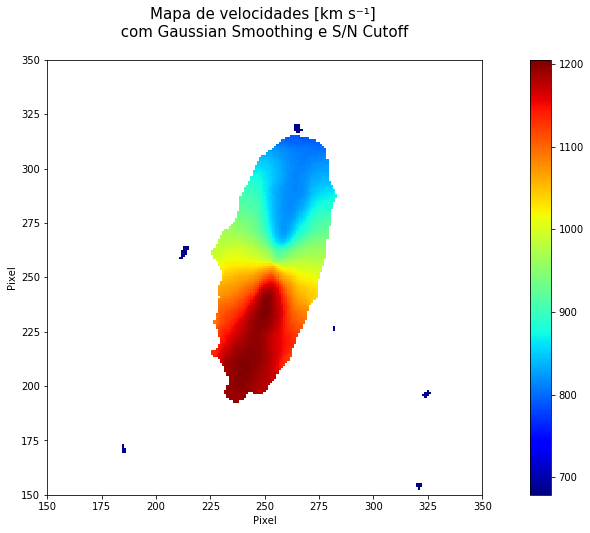

In [112]:
fig = plt.figure()
plt.figure(figsize=(17,8))

# plt.subplot(1, 2, 1)
# fig.patch.set_facecolor('xkcd:white')
# # plt.figure(figsize=(9,9))
# plt.imshow(masked_slab.with_spectral_unit(u.km/u.s, velocity_convention='radio').moment(order=1).hdu.data,
#            cmap= 'jet')
# plt.title("Mapa de velocidades [km s⁻¹] \n", fontsize=15)
# plt.xlabel('Pixel')
# plt.ylabel('Pixel')
# plt.colorbar()
# plt.xlim(100,400)
# plt.ylim(100,400)
# fig = plt.gcf()


# plt.subplot(1, 2, 2)
fig.patch.set_facecolor('xkcd:white')
# plt.figure(figsize=(9,9))
plt.imshow(new_masked_slab.with_spectral_unit(u.km/u.s, velocity_convention='radio').moment(order=1).hdu.data,
           cmap= 'jet')
plt.title("Mapa de velocidades [km s⁻¹] \n com Gaussian Smoothing e S/N Cutoff \n", fontsize=15)
plt.xlabel('Pixel')
plt.ylabel('Pixel')
plt.colorbar()
plt.xlim(150,350)
plt.ylim(150,350)
fig = plt.gcf()

plt.show()

# Obs.: Para salvar esse gráfico, descomente o seguinte comando:
fig.savefig('final.png', format='png')

In [20]:
# new_masked_slab = new_cube.with_mask(new_cube > 5*0.00004* new_cube.unit)
#  = (new_cube > 5*0.00005*u.Jy/u.beam)

In [ ]:
# fig = plt.subplots(2,2)
plt.figure(figsize=(17,8))

plt.subplot(2, 2, 1)
# fig.patch.set_facecolor('xkcd:white')
# plt.figure(figsize=(9,9))
plt.imshow(masked_slab.with_spectral_unit(u.km/u.s, velocity_convention='radio').moment(order=1).hdu.data,
           cmap= 'jet')
plt.title("Mapa de velocidades [km s⁻¹] \n", fontsize=15)
plt.xlabel('Pixel')
plt.ylabel('Pixel')
plt.colorbar()
plt.xlim(100,400)
plt.ylim(100,400)
fig = plt.gcf()
#-----------------------------------------------------------------------------------------------------------------

plt.subplot(2, 2, 2)
fig.patch.set_facecolor('xkcd:white')
# plt.figure(figsize=(9,9))
plt.imshow(new_masked_slab.with_spectral_unit(u.km/u.s, velocity_convention='radio').moment(order=1).hdu.data,
           cmap= 'jet')
plt.title("Mapa de velocidades [km s⁻¹] \n com Gaussian Smoothing e corte no S/N \n", fontsize=15)
plt.xlabel('Pixel')
plt.ylabel('Pixel')
plt.colorbar()
plt.xlim(100,400)
plt.ylim(100,400)
fig = plt.gcf()
#-----------------------------------------------------------------------------------------------------------------

# plt.subplot(2, 2, 3)
# fig.patch.set_facecolor('xkcd:white')
# # plt.figure(figsize=(9,9))
# plt.imshow(new_masked_slab.with_spectral_unit(u.km/u.s, velocity_convention='radio').moment(order=1).hdu.data,
#            cmap= 'jet')
# plt.title("Mapa de velocidades [km s⁻¹] \n com Gaussian Smoothing e corte no S/N \n", fontsize=15)
# plt.xlabel('Pixel')
# plt.ylabel('Pixel')
# plt.colorbar()
# plt.xlim(100,400)
# plt.ylim(100,400)
# fig = plt.gcf()
# #-----------------------------------------------------------------------------------------------------------------

# plt.subplot(2, 2, 4)
# fig.patch.set_facecolor('xkcd:white')
# # plt.figure(figsize=(9,9))
# plt.imshow(new_masked_slab.with_spectral_unit(u.km/u.s, velocity_convention='radio').moment(order=1).hdu.data,
#            cmap= 'jet')
# plt.title("Mapa de velocidades [km s⁻¹] \n com Gaussian Smoothing e corte no S/N \n", fontsize=15)
# plt.xlabel('Pixel')
# plt.ylabel('Pixel')
# plt.colorbar()
# plt.xlim(100,400)
# plt.ylim(100,400)
# fig = plt.gcf()

plt.show()

# Obs.: Para salvar esse gráfico, descomente o seguinte comando:
# fig.savefig('NGC 4698 mapa de velocidades.png', format='png')